# Lab 2: Clustering

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD2"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L2_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

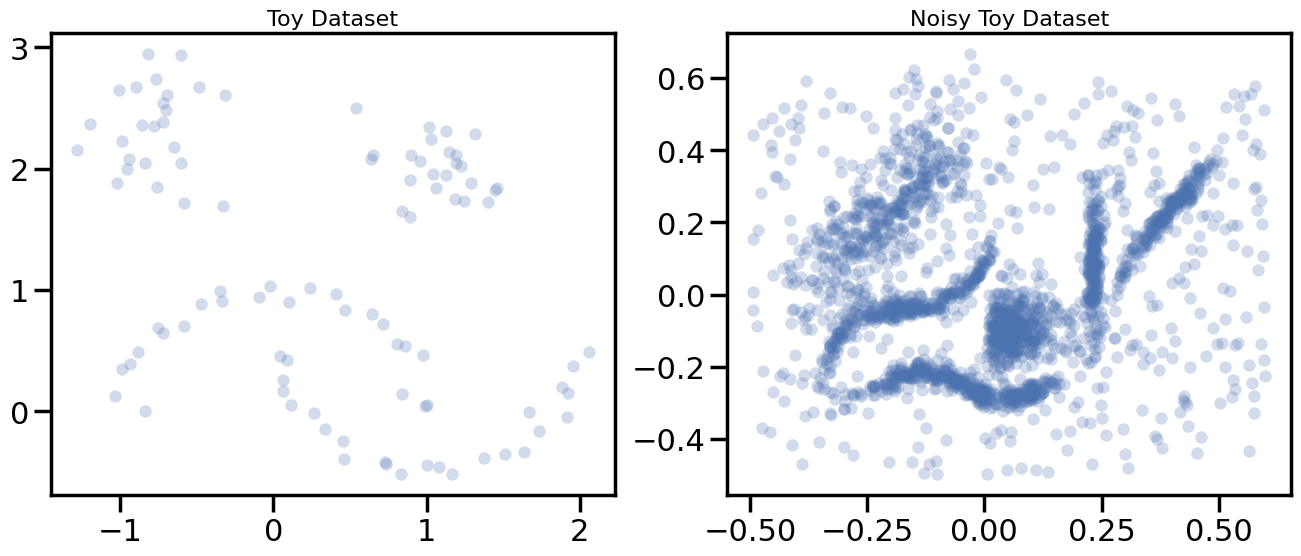

In [2]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show()

In [60]:
test_data_0.shape

(100, 2)

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

## Aglomerative Single Linkage clustering

c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Program1\anaconda3\envs\ml_kaggle\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


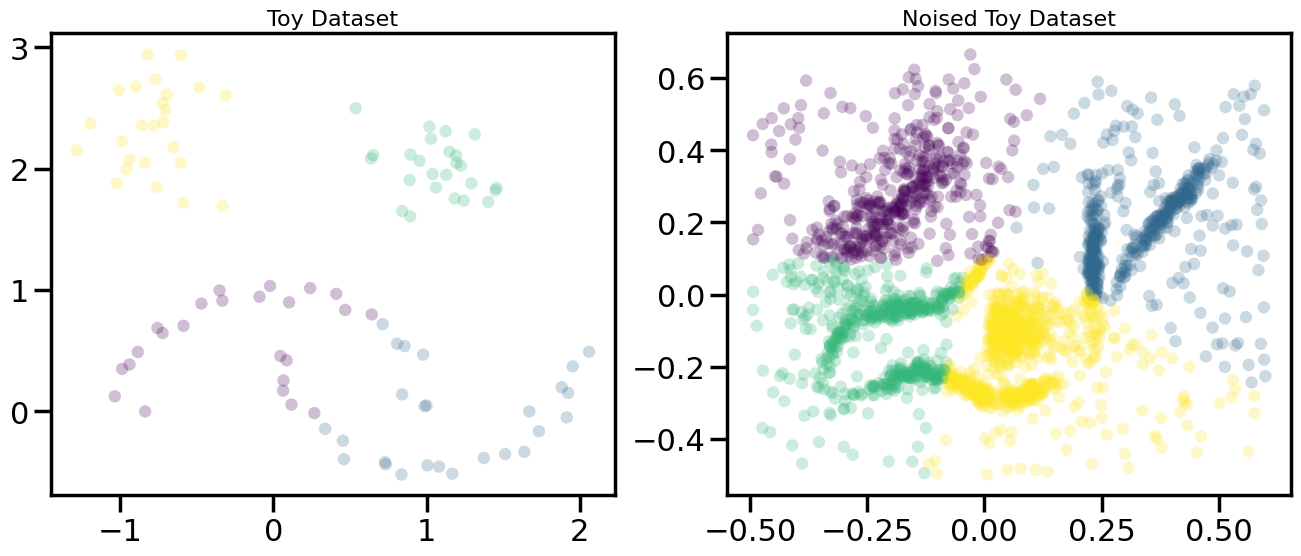

In [3]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=4, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show()

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [101]:
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance

class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        n_samples = X.shape[0]
        
        if self.metric_ != "precomputed":
            dist_matrix = distance.squareform(distance.pdist(X, metric=self.metric_))
        else:
            dist_matrix = X
        
        # Initialize clusters
        clusters = [[i] for i in range(n_samples)]
        cluster_ids = list(range(n_samples))
        self.hierarchy_ = [np.array(list(range(n_samples)))]
        self.linkage_matrix_ = []
        
        for k in range(n_samples - 1):
            # Find the two closest clusters
            min_dist = np.inf
            min_i, min_j = None, None
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = np.min([dist_matrix[a, b] for a in clusters[i] for b in clusters[j]])
                    if dist < min_dist:
                        min_dist = dist
                        min_i, min_j = i, j
            
            # Merge the two closest clusters
            new_cluster = clusters[min_i] + clusters[min_j]
            
            # Update linkage matrix
            self.linkage_matrix_.append([
                cluster_ids[min_i],
                cluster_ids[min_j],
                min_dist,
                len(new_cluster)
            ])

            cluster_ids = [x for i, x in enumerate(cluster_ids) if i not in [min_i, min_j]] + [n_samples + k]

            
            # Update clusters
            clusters = [c for idx, c in enumerate(clusters) if idx not in [min_i, min_j]]
            clusters.append(new_cluster)
            
            # Update hierarchy
            new_labels = np.full(n_samples, -1)
            for i, cluster in enumerate(clusters):
                for sample in cluster:
                    if sample < n_samples:
                        new_labels[sample] = i
            self.hierarchy_.append(new_labels)
        
        self.linkage_matrix_ = np.array(self.linkage_matrix_)
        
        # Update labels_ from the hierarchy level selected by n_clusters
        self.labels_ = self.hierarchy_[-self.n_clusters_]
        
        return self
            
    def plot_dendrogram(self, figsize=(12,12)):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''        
        plt.figure(figsize=figsize)
        dendrogram(self.linkage_matrix_, orientation='top')
        plt.show()

Apply the method to our toy datasets

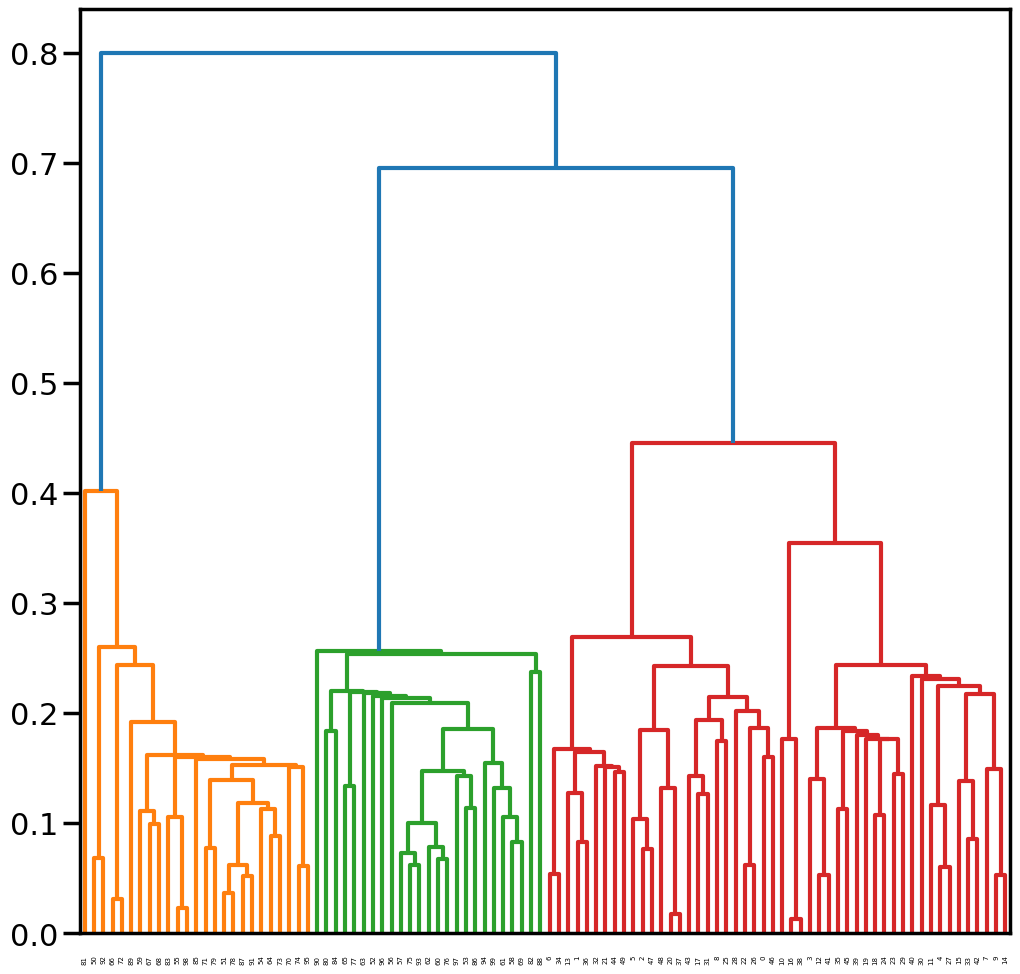

In [104]:
single_linkage_0 = my_SingleLinkageAglomerativeClustering(n_clusters=4).fit(test_data_0)
single_linkage_0.plot_dendrogram()

Try the different linkage methods implemented in `sklearn`  and comment

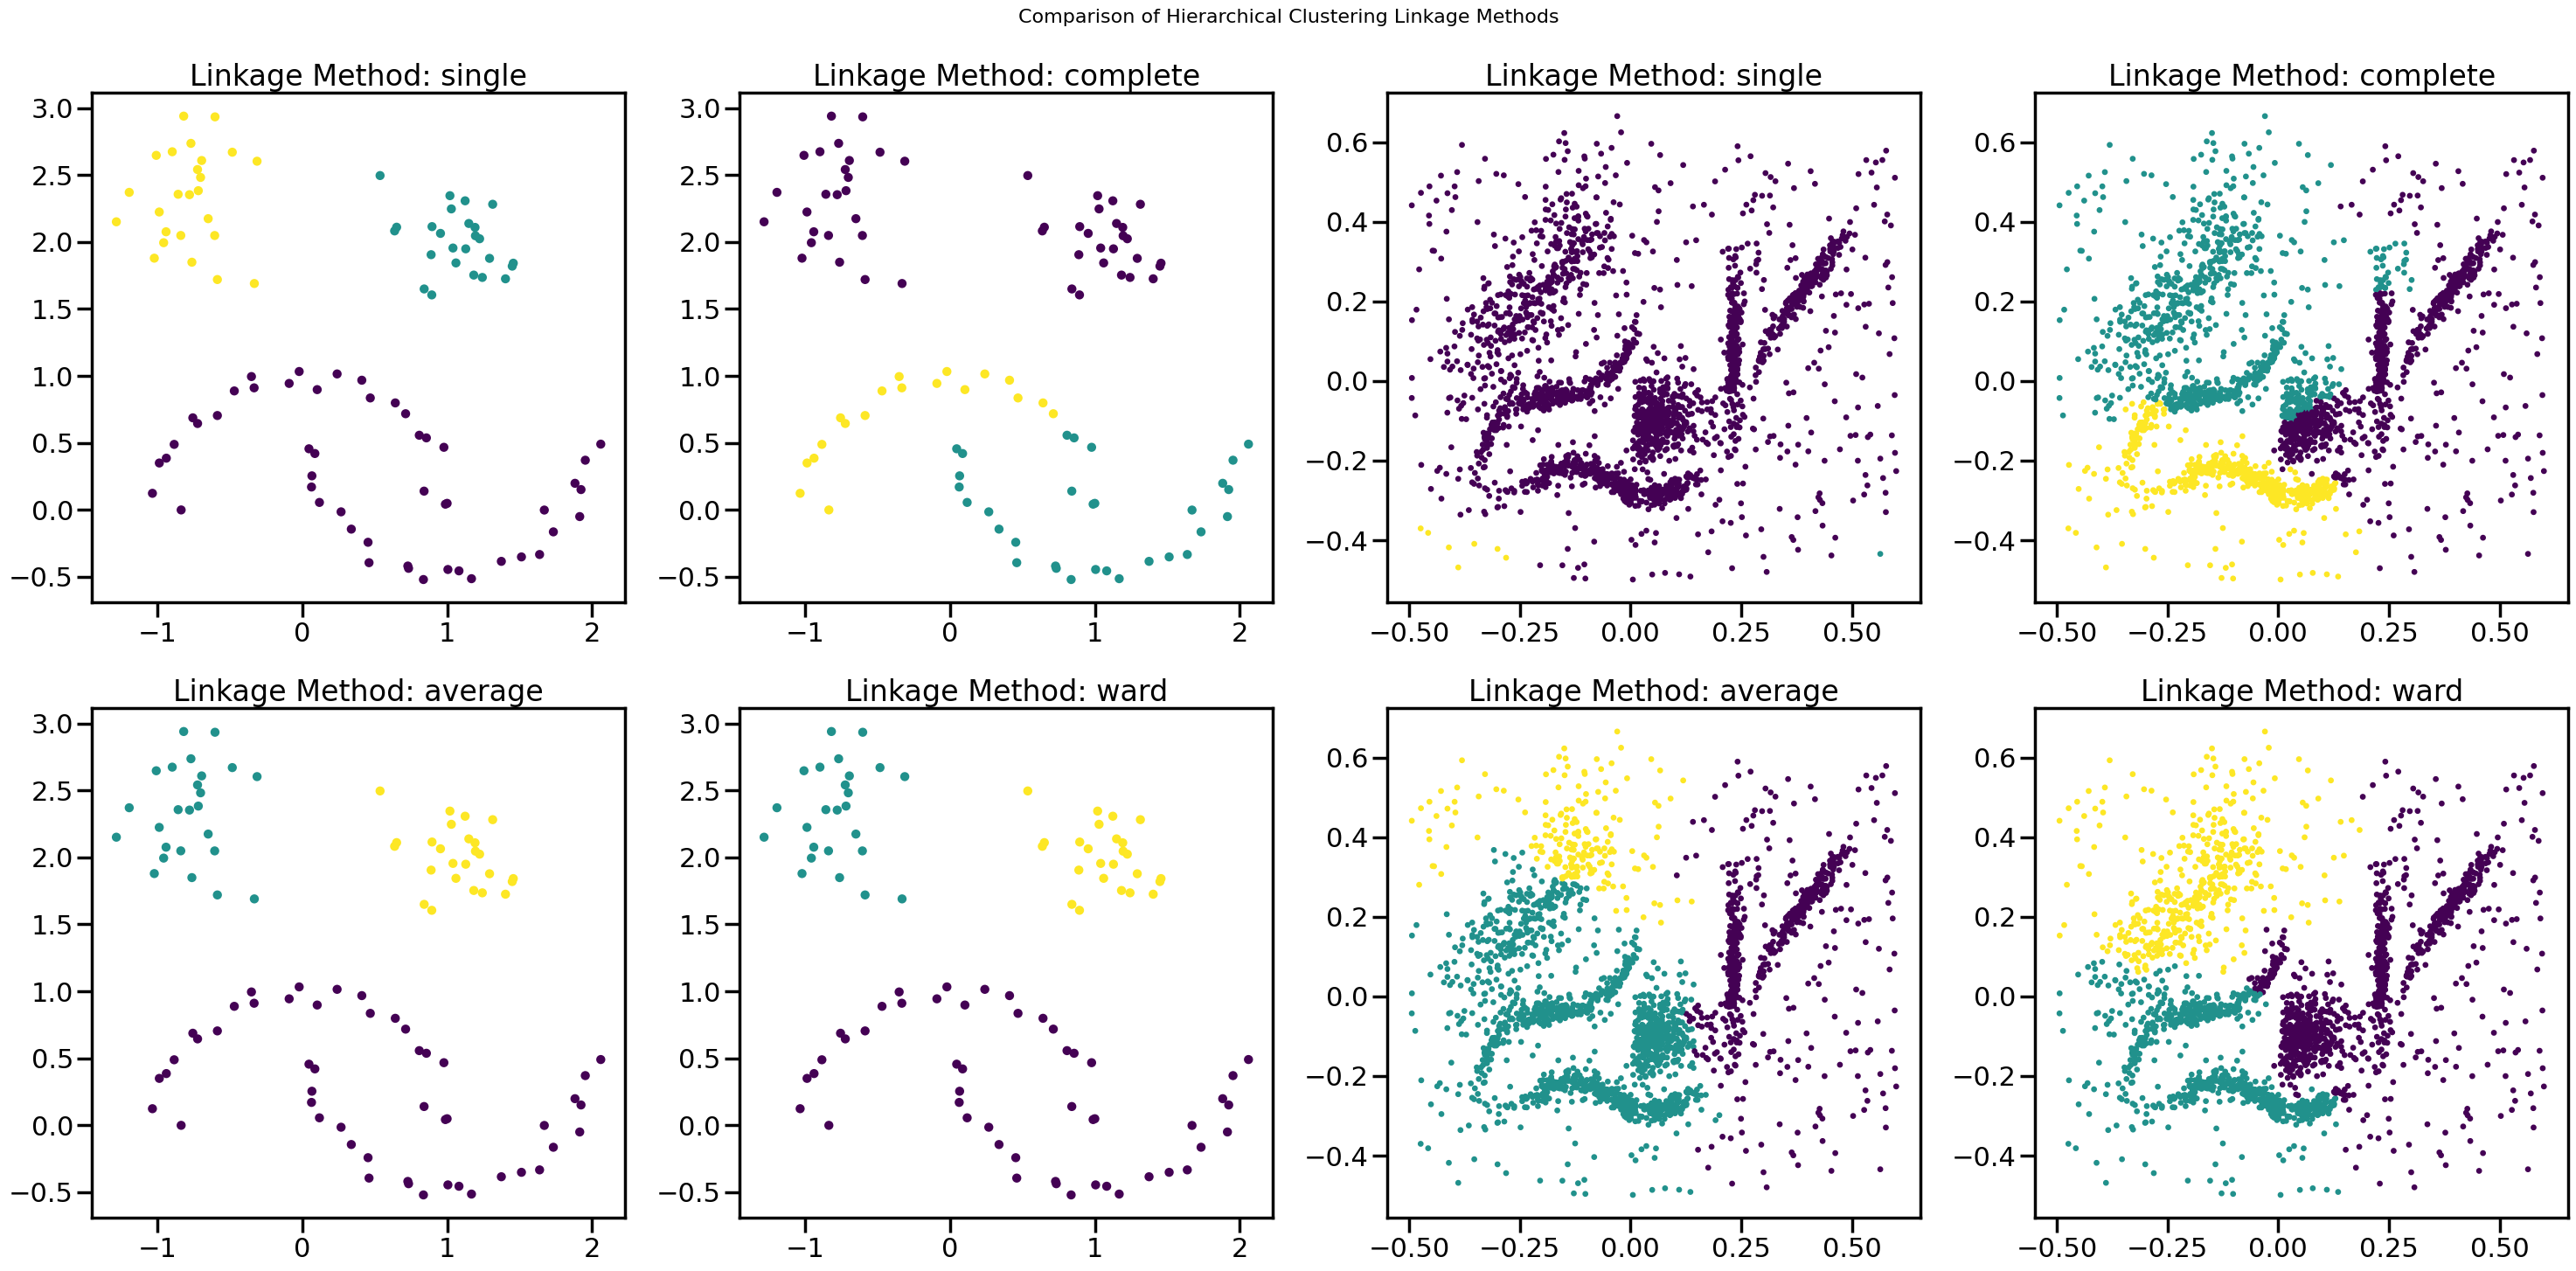

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


# List of linkage methods to test
linkage_methods = ['single', 'complete', 'average', 'ward']

# Set up the plot
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
fig.suptitle('Comparison of Hierarchical Clustering Linkage Methods', fontsize=16)

# Function to plot clusters
def plot_clusters(X, labels, ax, title, s=4):
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=s)
    ax.set_title(title)

# Perform clustering and plot results for each linkage method
for i, method in enumerate(linkage_methods):
    # Perform clustering
    clustering = AgglomerativeClustering(n_clusters=3, linkage=method)
    
    # Plot results
    row = i // 2
    col = i % 2
    clustering.fit(test_data_0)
    plot_clusters(test_data_0, clustering.labels_, axs[row, col], f'Linkage Method: {method}', s=30)

    clustering.fit(test_data_1)
    plot_clusters(test_data_1, clustering.labels_, axs[row, col+2], f'Linkage Method: {method}', s=8)

plt.tight_layout()
plt.show()

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

In [ ]:
import hdbscan

# TODO

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


In [ ]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [ ]:
# TODO:
# I = 
# S = 

- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

In [ ]:
# TODO

### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

In [ ]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

In [ ]:
# TODO